In [1]:
import os, shutil, pickle
from Bio import SeqIO
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Model, Sequential
from keras.models import Sequential
from keras.layers import Dense, Dropout, MaxPooling1D, Flatten, Conv1D, LSTM, CuDNNLSTM, Bidirectional
from keras.optimizers import RMSprop

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Randomly generate training data  
`train_x` has shape: (# of training data, max length of sequence, 4),
where the maximal length of sequence by default is 1000 and 4 reflects the one-hot encoding of one nucleotide(A, T, G, or C).

In [2]:
input_folder_path = "../../../temp/samples/"
output_folder_path = "../../../temp/new_output/"

# sample data from:
data_dir = "../../../3.species_24_only_07March2018/3.24_species_only/"

In [3]:
all_data_lst = np.array(os.listdir(data_dir))
n = len(all_data_lst)
num_samples = 200

np.random.seed(189)
sample_indices = np.random.choice(np.arange(n), num_samples, replace = False)
sample_files = all_data_lst[sample_indices]

for file in sample_files:
    print(file)
    shutil.copy(os.path.join(data_dir, file),
                        input_folder_path)

outlier_rm_with_length_VT26654.fa
outlier_rm_with_length_VT15830.fa
outlier_rm_with_length_VT17004.fa
outlier_rm_with_length_VT26330.fa
outlier_rm_with_length_VT10559.fa
outlier_rm_with_length_VT17649.fa
outlier_rm_with_length_VT21450.fa
outlier_rm_with_length_VT15159.fa
outlier_rm_with_length_VT18447.fa
outlier_rm_with_length_VT21149.fa
outlier_rm_with_length_VT11142.fa
outlier_rm_with_length_VT26763.fa
outlier_rm_with_length_VT17668.fa
outlier_rm_with_length_VT25271.fa
outlier_rm_with_length_VT23783.fa
outlier_rm_with_length_VT23949.fa
outlier_rm_with_length_VT21906.fa
outlier_rm_with_length_VT18437.fa
outlier_rm_with_length_VT17789.fa
outlier_rm_with_length_VT15722.fa
outlier_rm_with_length_VT1619.fa
outlier_rm_with_length_VT26010.fa
outlier_rm_with_length_VT17694.fa
outlier_rm_with_length_VT18418.fa
outlier_rm_with_length_VT19294.fa
outlier_rm_with_length_VT14720.fa
outlier_rm_with_length_VT10556.fa
outlier_rm_with_length_VT2470.fa
outlier_rm_with_length_VT19904.fa
outlier_rm_with_

In [4]:
# Use the following dictionary to perform the transformation
base_pairs = {'A': [1, 0, 0, 0], 
              'C': [0, 1, 0, 0],
              'G': [0, 0, 1, 0],
              'T': [0, 0, 0, 1],
              'a': [1, 0, 0, 0],
              'c': [0, 1, 0, 0],
              'g': [0, 0, 1, 0],
              't': [0, 0, 0, 1],
              'n': [0, 0, 0, 0],
              'N': [0, 0, 0, 0]}

file_num_limit = 10000    # The maximum number of files to be decoded
file_count = 0

# Iterate through every file
all_regions = []
for file in os.listdir(input_folder_path):
    # When the number of file decoded has reached the limit, stop
    if file_count < file_num_limit:
        data = list(SeqIO.parse(input_folder_path + file,"fasta"))
        for n in range(0, len(data)):
            # Extract the header information
            header = data[n].description.split('|')
            descr = data[n].description
            regionID = header[0]
            expressed = header[1]
            speciesID = header[2]
            strand = header[3]
            # Complement all sequences in the negative DNA strand
#             if strand == '-':
#                 # Using the syntax [e for e in base_pairs[n]] to create a new pointer for each position
#                 one_hot.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq.complement()]])
#             else:
        all_regions.append([descr, expressed, speciesID, [[e for e in base_pairs[n]] for n in data[n].seq]])
        file_count += 1
        
output_name = 'all_regions'
with open(output_folder_path + 'all_regions', mode="wb") as output:
    print("save to {}".format(os.path.join(output_folder_path, output_name)))
    pickle.dump(all_regions, output)

save to ../../../temp/new_output/all_regions


In [5]:
with open(os.path.join(output_folder_path, output_name), 'rb') as file:
    all_regions = pickle.load(file)

In [6]:
def curtail(lst, read_len):
    if len(lst) > read_len:
        lst = lst[:read_len]
    else:
        for i in range(read_len - len(lst)):
            lst.append([0, 0, 0, 0])
    return lst

In [7]:
max_len = 1000

train_x, train_y = [], []
for region in all_regions:
    y, x = int(region[1]), region[3]
    x = curtail(x, max_len)
    x = np.array(x).flatten()
    x = x.reshape((1000, 4))
    train_x.append(x)
    train_y.append(y)

train_x, train_y = np.array(train_x), np.array(train_y)

train_x.shape, train_y.shape

((200, 1000, 4), (200,))

Sanity check: overfit this small random dataset.

In [8]:
model = Sequential()
model.add(Conv1D(filters = 320, 
                 kernel_size = 26, 
                 padding = 'valid',
                 data_format = 'channels_last',
                 activation = 'relu'))
model.add(MaxPooling1D(pool_size = 5, strides = 5))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(320), input_shape=(1000, 8)))
model.add(Dropout(0.5))
model.add(Dense(160, activation = 'relu'))
model.add(Dense(50, activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
rmsprop = RMSprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsprop, loss='binary_crossentropy', metrics=['acc'])
history = model.fit(train_x, train_y, epochs=50, batch_size=10, validation_split=0.2)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 160 samples, validate on 40 samples
Epoch 1/50
160/160 [==============================] - 12s 74ms/step - loss: 0.6944 - acc: 0.4875 - val_loss: 0.6680 - val_acc: 0.7000
Epoch 2/50
160/160 [==============================] - 10s 64ms/step - loss: 0.6943 - acc: 0.5312 - val_loss: 0.6625 - val_acc: 0.7000
Epoch 3/50
160/160 [==============================] - 10s 64ms/step - loss: 0.6946 - acc: 0.5188 - val_loss: 0.6566 - val_acc: 0.7000
Epoch 4/50
160/160 [==============================] - 10s 64ms/step - loss: 0.6917 - acc: 0.5563 - val_loss: 0.6579 - val_acc: 0.7000
Epoch 5/50
160/160 [==============================] - 10s 65ms/step - loss: 0.6899 - acc: 0.5188 - val_loss: 0.6549 - val_acc: 0.7000
Epoch 6/50
160/160 [==============================

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 975, 320)          33600     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 195, 320)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 195, 320)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 640)               1640960   
_________________________________________________________________
dropout_2 (Dropout)          (None, 640)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 160)               102560    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                8050      
__________

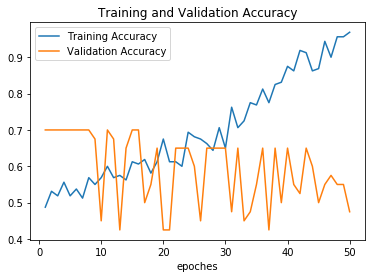

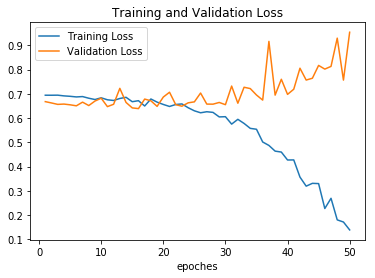

In [10]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, '-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('epoches')
plt.legend()

plt.figure()

plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, '-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoches')
plt.legend()

plt.show()

In [13]:
model.layers[0].get_weights()

[array([[[ 0.01301779,  0.00468555, -0.01263216, ...,  0.02155032,
          -0.00477678, -0.01079218],
         [-0.01317916,  0.01830828, -0.00881206, ...,  0.00778295,
          -0.0180556 , -0.00947639],
         [-0.00198024, -0.01837754, -0.02236319, ...,  0.01693841,
          -0.01575406,  0.01905267],
         [ 0.00114323, -0.00249048, -0.01007885, ...,  0.01103109,
          -0.02329759,  0.01221391]],
 
        [[-0.01409786, -0.02014912, -0.01587221, ...,  0.01060782,
          -0.00905827,  0.0062592 ],
         [-0.0208035 , -0.02185883, -0.01252533, ...,  0.01151452,
          -0.00269405, -0.01901037],
         [ 0.03306915, -0.01084121,  0.00129158, ...,  0.01677911,
           0.01041294,  0.00964352],
         [-0.023452  ,  0.01692676, -0.03013862, ..., -0.00862697,
          -0.00733462, -0.01993063]],
 
        [[ 0.0231621 , -0.01338581, -0.00519858, ...,  0.00461158,
          -0.01414347,  0.0086176 ],
         [-0.0207811 , -0.01211909,  0.00377518, ...,  0.0